<a href="https://colab.research.google.com/github/Ritishh00/GEN-AI/blob/main/GEN_AI_29_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import datasets
from tensorflow.keras.losses import MeanSquaredError , KLDivergence , BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
# Import ModelCheckpoint and EarlyStopping from tensorflow.keras.callbacks instead of tensorflow.keras.optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from skimage.transform import resize

In [ ]:
# %%
from tensorflow.keras.datasets import cifar10  # Import the cifar10 dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # Load the CIFAR-10 dataset
# %%


In [ ]:
x_train = x_train.astype('float32') / 255.0  # Normalize the training data
x_test = x_test.astype('float32') / 255.0  # Normalize the testing data


In [ ]:
latent_dim = 1024
image_shape = x_train[0].shape  # Get the shape directly using .shape
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import losses
from tensorflow.keras.losses import binary_crossentropy # Import binary_crossentropy


class VAE(keras.Model):
  def __init__(self, latent_dim, image_shape, beta):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.beta=beta

    self.encoder = keras.Sequential([
        layers.Input(shape=image_shape, name="Encoder_Input_Layer"),
        layers.Conv2D(32, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_2"),
        layers.Conv2D(64, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_4"),
        layers.Conv2D(128, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_6"),
        layers.Flatten(name="Encoder_Flatten"),
        ])

    # First, define self.z to hold the mean and log_var layers.
    self.z_mean = layers.Dense(latent_dim, name="z_Mean")
    self.z_log_var = layers.Dense(latent_dim, name="z_log_var")

    self.decoder = keras.Sequential([
        layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(8*8*64, activation='relu'),
        layers.Reshape((8,8,64)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])

    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  def encode(self,data):
    x=self.encoder(data)
    # Access z_mean and z_log_var directly
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    return z_mean, z_log_var

  def reparameterization(self,z_mean, z_log_var):
    batch=tf.shape(z_mean)[0]
    dim=tf.shape(z_mean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch, dim))
    z=z_mean+tf.exp(0.5*z_log_var)*epsilon
    return z

  def call(self,x):
    mean, logvar=self.encode(x)
    z=self.reparameterization(mean, logvar)
    x_recon=self.decode(z)
    return x_recon, mean, logvar

  def decode(self,data):
    return self.decoder(data)

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def recon_loss(self,data,reconstruction):
    # Use binary_crossentropy from tensorflow.keras.losses
    return tf.reduce_mean(binary_crossentropy(data,reconstruction))

  def kl_divergence(self, Z_logvar, Z_mu):
    kl_loss = -0.5 * tf.reduce_mean(1 + Z_logvar - Z_mu**2 - tf.math.exp(Z_logvar))
    return self.beta*kl_loss # Return kl_loss instead of just kl

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encode(data)
      z = self.reparameterization(z_mean, z_log_var)
      reconstruction = self.decode(z)

      reconstruction_loss = self.recon_loss(data, reconstruction)
      kl_loss = self.kl_divergence(z_log_var, z_mean)
      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

In [ ]:
  vae = VAE(latent_dim, image_shape, 0.3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=50, batch_size=512, callbacks=[early_stopping])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - kl_loss: 7.3547e-04 - loss: 0.6868 - reconstruction_loss: 0.6860
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - kl_loss: 0.0081 - loss: 0.6280 - reconstruction_loss: 0.6199
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - kl_loss: 0.0107 - loss: 0.6189 - reconstruction_loss: 0.6082
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0124 - loss: 0.6145 - reconstruction_loss: 0.6021
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: 0.0130 - loss: 0.6118 - reconstruction_loss: 0.5988
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: 0.0134 - loss: 0.6109 - reconstruction_loss: 0.5975
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - kl_loss: 0.0139 - loss: 0.6093 - reconstruction_loss: 0.5953
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0139 - loss: 0.6076 - reconstruction_loss: 0.5937
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0136 - loss: 0.605

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


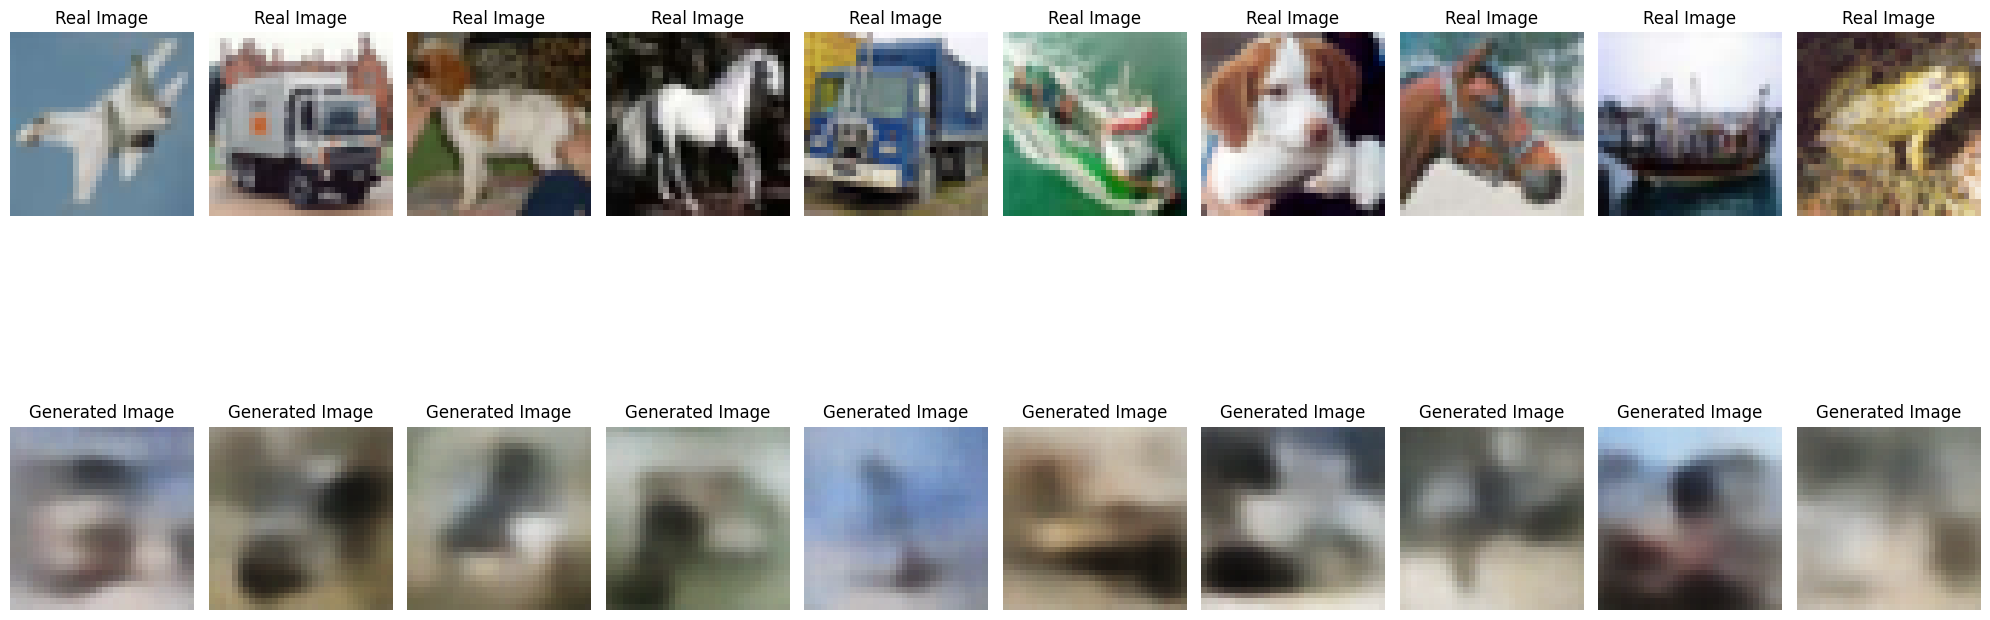

In [ ]:
def generate_images_from_latent_vectors(vae,num_images_to_generate):
  random_latent_vectors = np.random.normal(size=(num_images_to_generate, vae.latent_dim))
  generated_images = vae.decoder.predict(random_latent_vectors)
  return generated_images
# Call the function to generate images and assign the result to generated_images in global scope
generated_images = generate_images_from_latent_vectors(vae,20) # This line moved outside the function

def plot_real_and_generated_images(real_images, generated_images,num_images_to_generate):
    plt.figure(figsize=(20, 10))
    for i in range(num_images_to_generate):
        plt.subplot(2,num_images_to_generate,i+1)
        plt.imshow(real_images[i+10])
        plt.title('Real Image')
        plt.axis('off')
    for i in range(num_images_to_generate):
        plt.subplot(2,num_images_to_generate,num_images_to_generate + i + 1)
        plt.imshow(generated_images[i+10])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_real_and_generated_images(x_test, generated_images, 10)

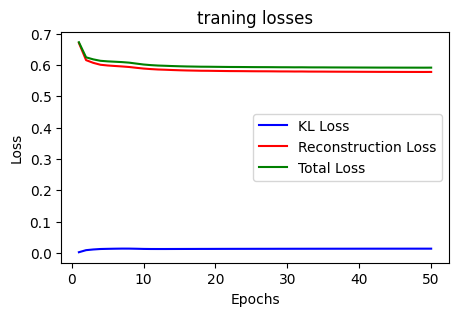

In [ ]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
# The total loss is stored under the key "loss"
total_loss = history.history['loss']
epochs = range(1, len(kl_loss) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('traning losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**12-02-25**

In [ ]:
!pip install torch torchvision
!pip install matplotlib
!pip install torchvision --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 858.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 784)
        self.fc5 = nn.Linear(10284, 28*28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))
        return x.view(x.size(0), 1, 28, 28)

In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return self.fc4(x)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
def wasserstein_loss(y_true, y_pred):
    return -torch.mean(y_true * y_pred)

In [ ]:
def compute_gradient_penalty(critic, real_images,fake_images, device):
    batch_size, C, H, W = real_images.size()
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)
    critic_outputs = critic(interpolated_images)
    gradient = torch.autograd.grad(
        outputs=critic_outputs,inputs = interpolated_images,
        grad_outputs=torch.ones(critic_outputs.size()).to(device),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradient.norm(2, dim=1) - 1) ** 2).mean()
    return penalty

In [ ]:
z_dim = 100
lr = 0.00005
n_critic = 5
lambda_gp = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

epochs = 100
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)

            critic_real = critic(real_images)
            critic_fake = critic(fake_images)

            gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)

            critic_loss = torch.mean(critic_fake) - torch.mean(critic_real) + lambda_gp * gradient_penalty

            optim_critic.zero_grad()
            critic_loss.backward(retain_graph=True)
            optim_critic.step()

        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        critic_fake = critic(fake_images)

        gen_loss = -torch.mean(critic_fake)

        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()



RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x784 and 10284x784)

**19-02-25**

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

import tensorflow as tf
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Changed 'model.dd' to 'model.add'
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


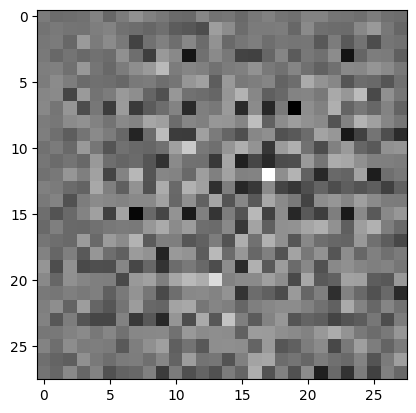

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00031615]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**Define the training loop**

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

**5-03-25**
**exp-3**

In [ ]:
!pip install torchvision
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
class generator(nn.Module):
    def __init__(self, z_dim):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024,28*28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))
        return x.view(x.size(0), 1, 28, 28)
class critic(nn.Module):
    def __init__(self):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(28*28,1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset= torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.35MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/100], Critic Loss: -9.842979431152344, Generator Loss: -3.3438005447387695


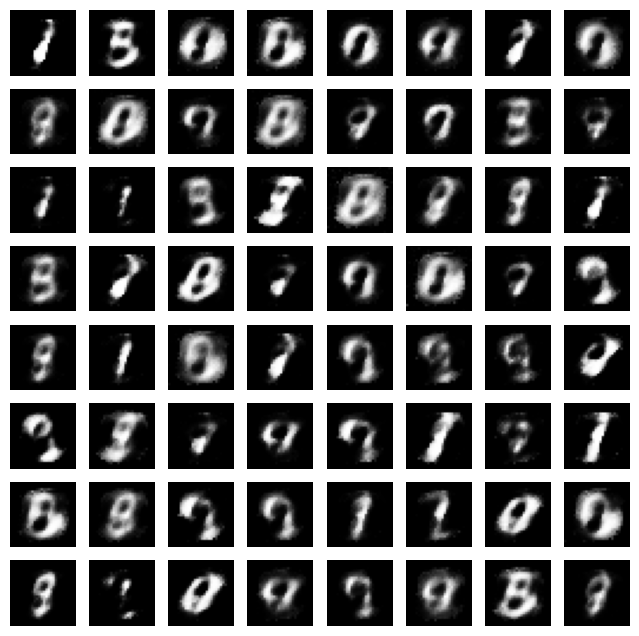

Epoch [2/100], Critic Loss: -10.114791870117188, Generator Loss: 9.356532096862793
Epoch [3/100], Critic Loss: -10.95762825012207, Generator Loss: 8.435827255249023
Epoch [4/100], Critic Loss: -10.625467300415039, Generator Loss: 8.60467529296875
Epoch [5/100], Critic Loss: -8.947105407714844, Generator Loss: 6.662735939025879
Epoch [6/100], Critic Loss: -8.663914680480957, Generator Loss: 3.6888885498046875
Epoch [7/100], Critic Loss: -7.900729656219482, Generator Loss: 2.9332308769226074
Epoch [8/100], Critic Loss: -7.923524379730225, Generator Loss: 1.8848623037338257
Epoch [9/100], Critic Loss: -7.399067401885986, Generator Loss: 2.825214385986328
Epoch [10/100], Critic Loss: -5.658411502838135, Generator Loss: 2.6560354232788086
Epoch [11/100], Critic Loss: -5.353157043457031, Generator Loss: 2.8327627182006836


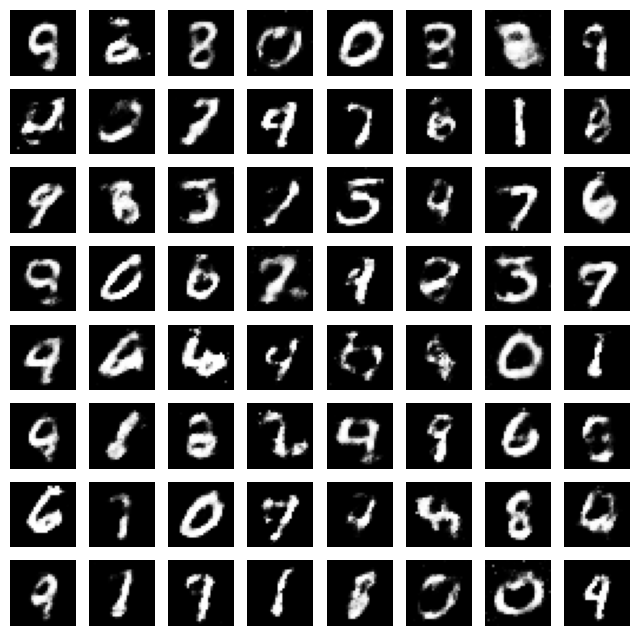

Epoch [12/100], Critic Loss: -5.599513530731201, Generator Loss: 2.334937572479248
Epoch [13/100], Critic Loss: -5.211324691772461, Generator Loss: 1.349679708480835
Epoch [14/100], Critic Loss: -5.092836856842041, Generator Loss: 2.401179552078247


In [ ]:
!pip install torchvision
!pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = torch.autograd.grad(outputs=d_interpolates,inputs=interpolates,grad_outputs=fake,create_graph=True,retain_graph=True,only_inputs=True,)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty
class generator(nn.Module):
    def __init__(self, z_dim):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 28 * 28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))
        return x.view(x.size(0), 1, 28, 28)
class critic(nn.Module):
    def __init__(self):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return self.fc4(x)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
z_dim = 100
lr = 0.00005
n_critic = 5
lambda_gp = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator(z_dim).to(device)
critic = critic().to(device)
optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))
epochs = 100
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)
            critic_real = critic(real_images)
            critic_fake = critic(fake_images)
            gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)
            critic_loss = torch.mean(critic_fake) - torch.mean(critic_real) + lambda_gp * gradient_penalty
            optim_critic.zero_grad()
            critic_loss.backward(retain_graph=True)
            optim_critic.step()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        critic_fake = critic(fake_images)
        gen_loss = -torch.mean(critic_fake)
        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()
    print(f'Epoch [{epoch + 1}/{epochs}], Critic Loss: {critic_loss.item()}, Generator Loss: {gen_loss.item()}')
    if epoch % 10 == 0:
        with torch.no_grad():
            test_z = torch.randn(64, z_dim).to(device)
            generated_images = generator(test_z)
            generated_images = generated_images.cpu().data
            generated_images = generated_images.view(64, 28, 28)
            plt.figure(figsize=(8, 8))
            for i in range(64):
                plt.subplot(8, 8, i + 1)
                plt.imshow(generated_images[i], cmap='gray')
                plt.axis('off')
            plt.show()

# **EXP 4**

# **Defining Accelerator**

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim
import torch.utils as utils

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


In [ ]:
!pip install torchvision
!pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import zipfile # Import the zipfile module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# **Loading Training Data**

In [ ]:
image_size = 64
transform = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
IMAGE_PATH = '/content/archive (1).zip'
EXTRACT_DIR = '/content/images'  # Define an extraction directory

with zipfile.ZipFile(IMAGE_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

dset = dataset.ImageFolder(root=EXTRACT_DIR, transform=transform)
dataloader = utils.data.DataLoader(dset, batch_size=128, shuffle=True, num_workers=2, drop_last=True)

NameError: name 'transforms' is not defined

# **Visualizing the Data**

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose((vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True)).cpu().numpy(), (1, 2, 0)))

NameError: name 'dataloader' is not defined

In [ ]:
def weight_init(instance):
    classname = instance.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
        nn.init.constant_(instance.bias.data, 0.0)

# **Discriminator Model**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False)

    def forward(self, x):
        x = x.view(-1, 3, 64, 64)
        x = F.leaky_relu(self.conv1(x), 0.2, inplace = True)
        x = self.conv2(x)
        x = F.leaky_relu(self.conv2_bn(x), 0.2, inplace = True)
        x = self.conv3(x)
        x = F.leaky_relu(self.conv3_bn(x), 0.2, inplace = True)
        x = self.conv4(x)
        x = F.leaky_relu(self.conv4_bn(x), 0.2, inplace = True)
        x = self.conv5(x)
        x = F.sigmoid(x)
        out = x.view(-1, 1)

        return out

NameError: name 'nn' is not defined

# **Generator Model**

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(100, 512, kernel_size = 4, stride = 1, padding = 0, bias = False)
        self.conv_transpose1_bn = nn.BatchNorm2d(512)
        self.conv_transpose2 = nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv_transpose2_bn = nn.BatchNorm2d(256)
        self.conv_transpose3 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv_transpose3_bn = nn.BatchNorm2d(128)
        self.conv_transpose4 = nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv_transpose4_bn = nn.BatchNorm2d(64)
        self.conv_transpose5 = nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False)

    def forward(self, x):
        x = x.view(-1, 100, 1, 1)
        x = self.conv_transpose1(x)
        x = F.relu(self.conv_transpose1_bn(x), inplace = True)
        x = self.conv_transpose2(x)
        x = F.relu(self.conv_transpose2_bn(x), inplace = True)
        x = self.conv_transpose3(x)
        x = F.relu(self.conv_transpose3_bn(x), inplace = True)
        x = self.conv_transpose4(x)
        x = F.relu(self.conv_transpose4_bn(x), inplace = True)
        x = self.conv_transpose5(x)
        out = torch.tanh(x)

        return out

# **Creating Model Instances**

In [ ]:
D = Discriminator()
D = D.to(device)
D = D.float()
D.apply(weight_init)
print(D)

G = Generator()
G = G.to(device)
G = G.float()
G.apply(weight_init)
print(G)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Generator(
  (conv_transpose1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv_transpose1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose2): ConvTranspose2d(512, 256, kernel_s

# **Defining Losses**

In [ ]:
loss = nn.BCELoss()
def real_loss_fn(real_out):
    labels = torch.ones(real_out.size()[0], 1).to(device)
    loss_real = loss(real_out.squeeze(), labels.squeeze())
    return loss_real

def fake_loss_fn(fake_out):
    labels = torch.zeros(fake_out.size()[0], 1).to(device)
    loss_fake = loss(fake_out.squeeze(), labels.squeeze())
    return loss_fake

# **Defining Optimizers**

In [ ]:
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
def train(D, G, dataloader, disc_opt, gen_opt, num_epochs, fac, batch_size = 128):

    disc_losses = []
    gen_losses = []

    fixed_noise = torch.randn(64, 100).to(device)

    D.train()
    G.train()

    for epoch in range(num_epochs + 1):

        gen_loss_total = 0
        disc_loss_total = 0

        for i, data in enumerate(dataloader, 0):
            disc_opt.zero_grad()

            x = data[0].to(device)
            real_out = D(x.float())
            real_loss = real_loss_fn(real_out)

            gen_in1 = torch.randn(batch_size, 100).to(device)
            disc_gen_in1 = G(gen_in1.float()).detach()
            fake_out = D(disc_gen_in1.float())
            fake_loss = fake_loss_fn(fake_out)

            disc_loss = real_loss + fake_loss
            disc_loss_total += disc_loss

            disc_loss.backward()
            disc_opt.step()

            gen_opt.zero_grad()

            gen_in2 = torch.randn(batch_size, 100).to(device)
            disc_gen_in2 = G(gen_in2.float())
            real_fake_out = D(disc_gen_in2.float())
            gen_loss = real_loss_fn(real_fake_out)
            gen_loss_total += gen_loss

            gen_loss.backward()
            gen_opt.step()

        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        print("Epoch ", epoch, " - ", "Discriminator Loss: ", disc_loss_total/len(dataloader), " Generator Loss: ", gen_loss_total/len(dataloader))

        if epoch % fac == 0:
            G.eval()
            sample_out = G(fixed_noise.float())
            G.train()

            plt.figure(figsize = (8,8))
            plt.axis('off')

            sample_out = vutils.make_grid(sample_out, padding = 2, normalize = True).cpu().detach().numpy()
            sample_out = np.transpose(sample_out, (1, 2, 0))
            plt.imshow(sample_out)

    return disc_losses, gen_losses

In [ ]:
disc_losses, gen_losses = train(D, G, dataloader, disc_opt, gen_opt, 5, 1)

NameError: name 'train' is not defined

# **Plotting Losses**

In [ ]:
disc_losses = np.array(disc_losses)
gen_losses = np.array(gen_losses)
plt.figure(figsize = (10, 5))
plt.title('Discriminator and Generator Losses')
plt.plot(disc_losses, label = 'Discriminator')
plt.plot(gen_losses, label = 'Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Experiment 5**
***CGAN2***

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm


In [22]:
batch_size = 16
epoch_count = 50
noise_dim = 100
tags = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
img_size = 32
(X_train, Y_train), (_,_) = cifar10.load_data()

X_train = (X_train - 127.5) / 127.5
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

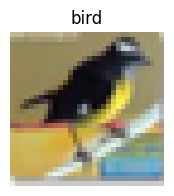

In [23]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx],scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[Y_train[idx][0]])
plt.show()

In [24]:
bce_loss = tf.keras.losses.BinaryCrossentropy()


def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real)
    fake_loss = bce_loss(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds)

d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

In [29]:
def build_generator():
  # label input
    in_label = tf.keras.layers.Input(shape=(1,))

    # Define n_class here, representing the number of classes (10 for CIFAR-10)
    n_class = 10

    # create an embedding layer for all the 10 classes in the form of a vector
    # of size 50
    li = tf.keras.layers.Embedding(n_class, 50)(in_label)

    n_nodes = 8 * 8
    li = tf.keras.layers.Dense(n_nodes)(li)
    # reshape the layer
    li = tf.keras.layers.Reshape((8, 8, 1))(li)

    # image generator input
    in_lat = tf.keras.layers.Input(shape=(noise_dim,))

    n_nodes = 128 * 8 * 8
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

    # merge image gen and label input
    merge = tf.keras.layers.Concatenate()([gen, li])

    gen = tf.keras.layers.Conv2DTranspose(
        128, (4, 4), strides=(2, 2), padding='same')(merge)  # 16x16x128
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    gen = tf.keras.layers.Conv2DTranspose(
        128, (4, 4), strides=(2, 2), padding='same')(gen)  # 32x32x128
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    out_layer = tf.keras.layers.Conv2D(
        3, (8, 8), activation='tanh', padding='same')(gen)  # 32x32x3

    model = Model([in_lat, in_label], out_layer)
    return model

g_model = build_generator()
g_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8192)           │        827,392 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 50)          │            500 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 8192)           │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 64)          │          3,264 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 8, 8, 128)      │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8, 8, 1)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 129)      │              0 │ reshape_1[0][0],       │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 128)    │        264,320 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 128)    │        262,272 │ leaky_re_lu_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 3)      │         24,579 │ leaky_re_lu_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
def build_discriminator():

  # label input
  in_label = tf.keras.layers.Input(shape=(1,))

  # Define n_class here, representing the number of classes (10 for CIFAR-10)
  n_class = 10  # This line is added to define n_class

  #This vector of size 50 will be learnt by the discriminator
  li = tf.keras.layers.Embedding(n_class, 50)(in_label)

  n_nodes = img_size * img_size
  li = tf.keras.layers.Dense(n_nodes)(li)

  li = tf.keras.layers.Reshape((img_size, img_size, 1))(li)


  # image input
  in_image = tf.keras.layers.Input(shape=(img_size, img_size, 3))

  merge = tf.keras.layers.Concatenate()([in_image, li])


  #We will combine input label with input image and supply as inputs to the model.
  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Flatten()(fe)

  fe = tf.keras.layers.Dropout(0.4)(fe)

  out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)

  # define model the model.
  model = Model([in_image, in_label], out_layer)

  return model

d_model = build_discriminator()
d_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │            500 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1024)        │         52,224 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 32, 32, 1)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 4)      │              0 │ input_layer_5[0][0],   │
│ (Concatenate)             │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 128)    │          4,736 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 8, 8, 128)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8192)           │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          8,193 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 213,237 (832.96 KB)

 Trainable params: 213,237 (832.96 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compiles the train_step function into a callable TensorFlow graph
@tf.function
def train_step(dataset):

    real_images, real_labels = dataset
    # Sample random points in the latent space and concatenate the labels.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model([random_latent_vectors, real_labels])

    # Train the discriminator.
    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels])
        pred_real = d_model([real_images, real_labels])

        d_loss = discriminator_loss(pred_real, pred_fake)

    grads = tape.gradient(d_loss, d_model.trainable_variables)
    # print(grads)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    #-----------------------------------------------------------------#

    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

    # Train the generator
    with tf.GradientTape() as tape:
        fake_images = g_model([random_latent_vectors, real_labels])
        predictions = d_model([fake_images, real_labels])
        g_loss = generator_loss(predictions)

    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))

    return d_loss, g_loss


In [28]:
# Helper function to plot generated images
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)

    for l in np.arange(10):
      random_noise = tf.random.normal(shape=(num_samples, noise_dim))
      label = tf.ones(num_samples)*l
      gen_imgs = g_model.predict([random_noise, label])
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])

        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()


Epoch:  50


100%|██████████| 3125/3125 [00:42<00:00, 72.71it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


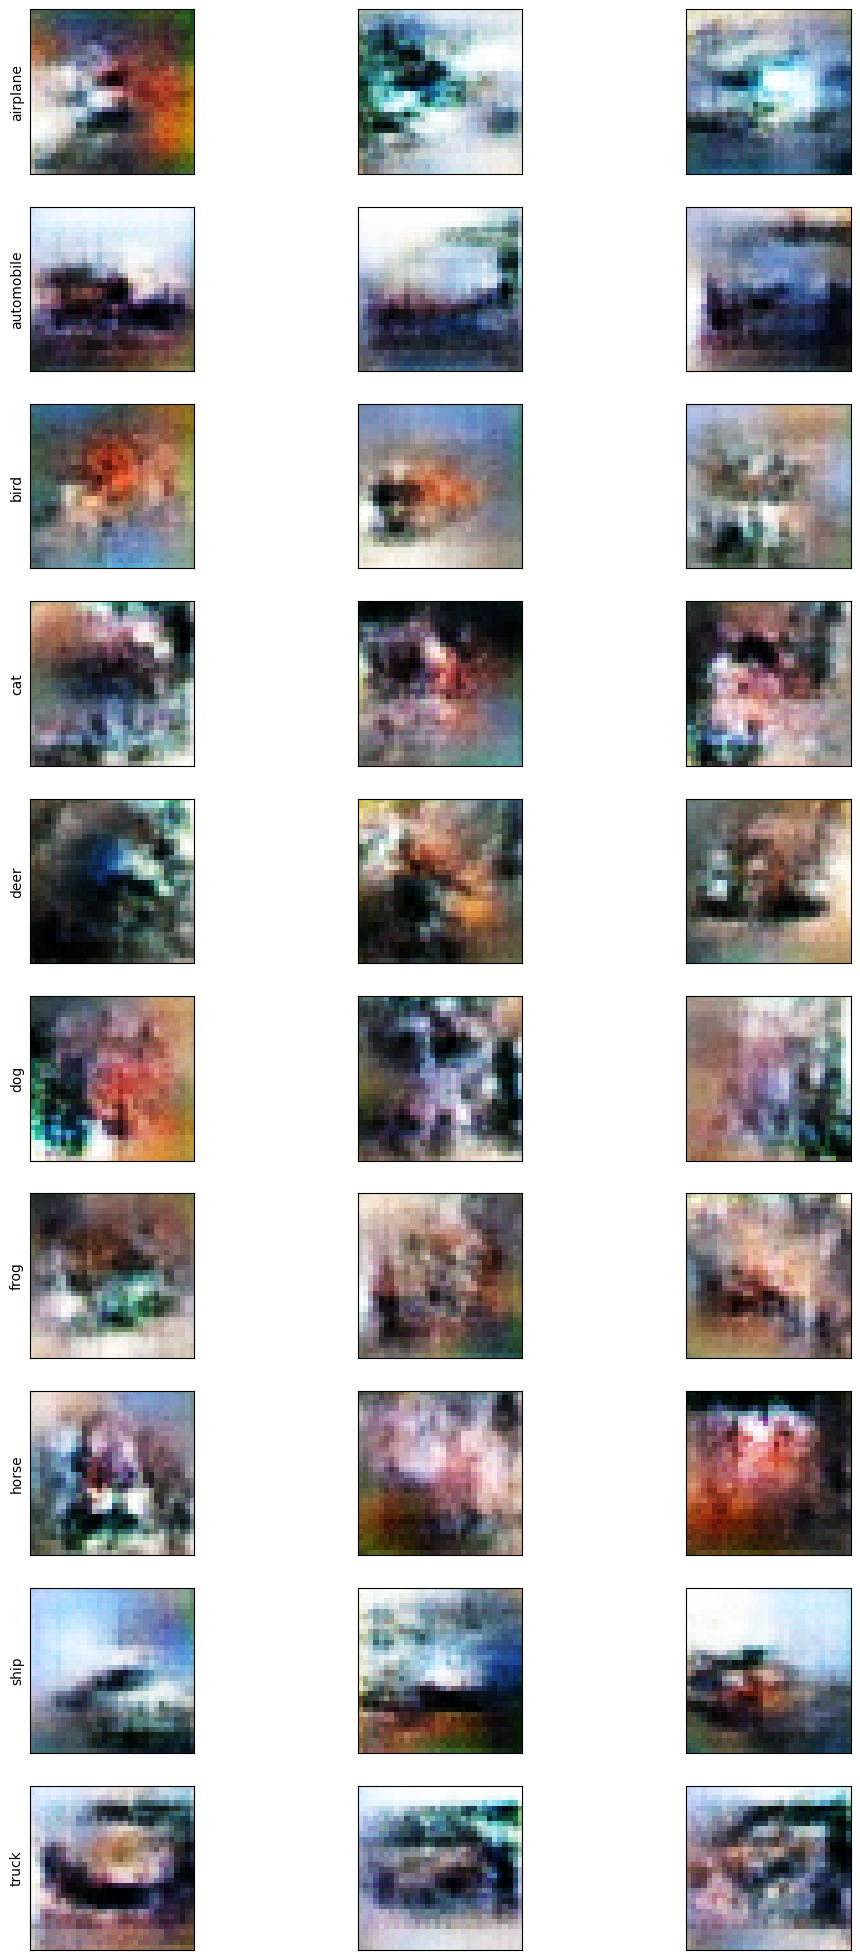

Epoch: 0 -- Generator Loss: 0.8729550242424011, Discriminator Loss: 1.279995322227478

Took 47.026352643966675 seconds. 


Epoch:  50


100%|██████████| 3125/3125 [00:41<00:00, 74.72it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


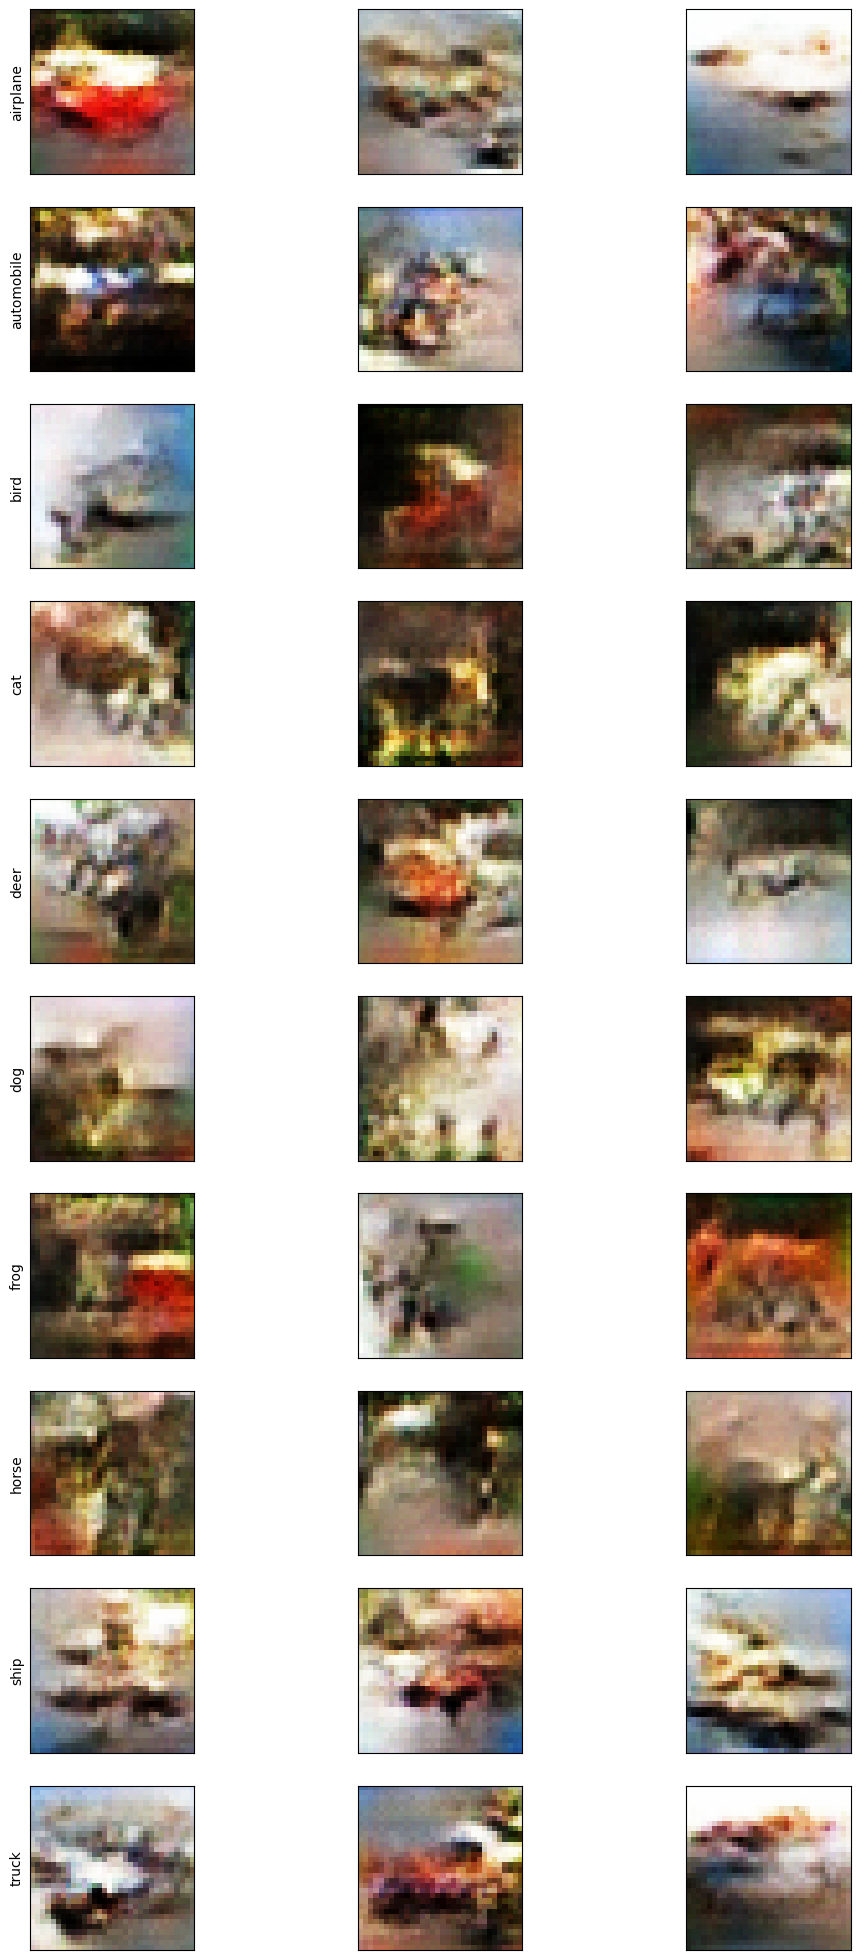

Epoch: 1 -- Generator Loss: 0.8733021020889282, Discriminator Loss: 1.2933989763259888

Took 44.7223436832428 seconds. 


Epoch:  50


 70%|███████   | 2195/3125 [00:29<00:12, 74.42it/s]

In [ ]:
def train(dataset, epochs=epoch_count):
    # Define n_class here, representing the number of classes (10 for CIFAR-10)
    n_class = 10  # This line is added

    for epoch in range(epochs):
        print('Epoch: ', epochs)
        d_loss_list = []
        g_loss_list = []
        q_loss_list = []
        start = time.time()

        itern = 0
        for image_batch in tqdm(dataset):
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            itern = itern + 1

        show_samples(3, n_class, g_model)

        print(f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
        print(f'Took {time.time() - start} seconds. \n\n')


train(dataset, epochs=epoch_count)